In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on device :', device)

training on device : cuda


In [ ]:
imt_logo=np.zeros((8,16))
imt_logo[0,:]=[1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
imt_logo[1,:]=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
imt_logo[2,:]=[1,0,0,1,1,1,0,1,0,1,0,1,1,1,0,0]
imt_logo[3,:]=[0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,1]
imt_logo[4,:]=[1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0]
imt_logo[5,:]=[0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,1]
imt_logo[6,:]=[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
imt_logo[7,:]=[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]



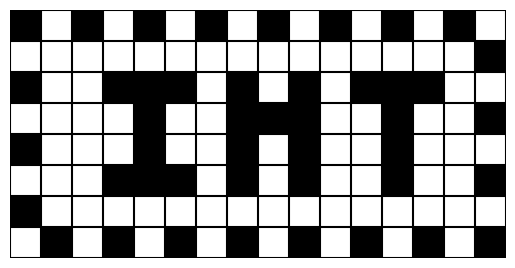

In [ ]:
plt.imshow(imt_logo, cmap='binary')
plt.axis('off')
rows, cols = imt_logo.shape
for i in range(rows + 1):
    plt.axhline(y=i - 0.5, color='black', linewidth=1.5)  # Horizontal lines

for j in range(cols + 1):
    plt.axvline(x=j - 0.5, color='black', linewidth=1.5)  # Turn off axis
plt.show()

In [ ]:
imt_logo=np.reshape(imt_logo,(128,))
imt_logo_tensor=torch.tensor(imt_logo).to(device)

In [ ]:
class WatermarkLoss(nn.Module):
    def __init__(self,key,mark):
        super(WatermarkLoss, self).__init__()
        self.key=key
        self.mark=mark.float()

    def forward(self,weights):
        y = torch.mean(weights, dim=(3,4)).to(device)
        #print("y shape", y.shape)
        z = y.view(1, -1)
        d=torch.sigmoid(torch.matmul(z, self.key))
        d=d.squeeze()
        d=d.float()
        loss=F.binary_cross_entropy(d, self.mark)
        return loss

In [ ]:
bits = 128
key = torch.randn(128*64*2,bits).to(device)
mark = imt_logo_tensor[:bits]
mark=mark.double()
waterloss=WatermarkLoss(key,mark)

In [ ]:
def extract_watermark(model, key):
    y = torch.mean(model.up1.weight, dim=(3,4))
    z = y.view(1, -1)
    d=torch.sigmoid(torch.matmul(z,key))
    d=d.squeeze()
    d=d.float()
    return d

In [ ]:
# Data directory
#data_dir = '/Users/noegutierrez/Documents/ecole/MCE/project-machine-learning/dataset/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
data_dir = 'C:/Users/noebi/Documents/ecole/fiseA3/mce/project_ml/dataset/archive/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

save_dir = 'models/ushida_reduced'
os.makedirs(save_dir, exist_ok=True)

In [ ]:

def resize_depth_layer(input_tensor, n_height, n_width):
    resized_depth_layers = []

    # Iterate over each depth layer
    for d in range(input_tensor.shape[-1]):
        # Extract the depth layer
        depth_layer = input_tensor[:,:,:, d]
        # Resize the depth layer to the desired size
        resized_depth_layer = torch.nn.functional.interpolate(depth_layer.unsqueeze(0), size=(n_height, n_width), mode='bilinear', align_corners=False).squeeze(0)
        # Append the resized depth layer to the list
        resized_depth_layers.append(resized_depth_layer)

    # Stack the resized depth layers along the depth dimension
    resized_tensor = torch.stack(resized_depth_layers, dim=-1)

    return resized_tensor



# Function to save the model
def save_model(model, optimizer, epoch, loss):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(state, os.path.join(save_dir, f'model_epoch_{epoch}.pt'))


# Function to plot training and validation loss
def plot_loss(train_losses, val_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [ ]:
def dice_coefficient(predicted, target):
    smooth = 1e-6  # to avoid division by zero
    intersection = (predicted * target).sum()
    return (2. * intersection + smooth) / (predicted.sum() + target.sum() + smooth)

def iou(predicted, target):
    smooth = 1e-6
    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)


In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet3D, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool3d((2, 2, 1))  # reduce only x, y dims, not z
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool3d((2, 2, 1))  # reduce only x, y dims, not z

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose3d(512, 256, kernel_size=(2, 2, 1), stride=(2, 2, 1))
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(2, 2, 1), stride=(2, 2, 1))
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck(p3)

        # Decoder
        u3 = self.up3(b)
        cat3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(cat3)

        u2 = self.up2(d3)
        cat2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(cat2)

        u1 = self.up1(d2)
        cat1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(cat1)

        out = self.final(d1)
        return out


In [ ]:
# Custom Dataset Definition
class BratsDataset(Dataset):
    def __init__(self, data_dir, transform=None, slice1=97, slice2=101, num_samples=None, num_validation_samples=0, validation=False):
        self.data_dir = data_dir
        self.transform = transform
        self.validation = validation
        self.slice1 = slice1
        self.slice2 = slice2
        self.num_samples = num_samples
        self.num_validation_samples = num_validation_samples
        self.patient_folders = sorted([folder for folder in os.listdir(data_dir) if folder.startswith('BraTS20_Training')])
        if self.num_samples is not None:
            self.patient_folders = self.patient_folders[:self.num_samples]

        # Divide dataset into training and validation sets
        if self.num_validation_samples > 0:
            self.train_patient_folders = self.patient_folders[:-num_validation_samples]
            self.val_patient_folders = self.patient_folders[-num_validation_samples:]
        else:
            self.train_patient_folders = self.patient_folders
            self.val_patient_folders = []
        if self.validation :
            # print('validation', self.validation)
            # print('len val patient folders', len(self.val_patient_folders))
            # print('len train_patient foldes', len(self.train_patient_folders))
            self.train_patient_folders = self.val_patient_folders
            #print('new len train patient folders', len(self.train_patient_folders))
    def __len__(self):
        return len(self.train_patient_folders)

    def __getitem__(self, idx):
        folder_name = self.train_patient_folders[idx]
        #print('len de train patient folders dans get item',len(self.train_patient_folders))
        flair_path = os.path.join(self.data_dir, folder_name, f'{folder_name}_flair.nii')
        t1ce_path = os.path.join(self.data_dir, folder_name, f'{folder_name}_t1ce.nii')
        seg_path = os.path.join(self.data_dir, folder_name, f'{folder_name}_seg.nii')
        flair_img = nib.load(flair_path).get_fdata()[:,:,self.slice1:self.slice2]
        t1ce_img = nib.load(t1ce_path).get_fdata()[:,:,self.slice1:self.slice2]
        seg_img = nib.load(seg_path).get_fdata()[:,:,self.slice1:self.slice2]

        # Convert to PyTorch tensors
        flair_img = torch.tensor(flair_img).float()
        t1ce_img = torch.tensor(t1ce_img).float()
        seg_img = torch.tensor(seg_img).float()

        # Replace all occurrences of 4 with 3
        seg_img[seg_img == 4] = 3

        # Combine flair and t1ce images along the channel dimension
        input_img = torch.stack((flair_img, t1ce_img), dim=0)

        # Resize images
        new_width = 128
        new_height = 128
        input_img = resize_depth_layer(input_img, new_height, new_width)
        seg_img = resize_depth_layer(seg_img.unsqueeze(0), new_height, new_width).squeeze(0).long()

        if self.transform:
            input_img = self.transform(input_img)
            seg_img = self.transform(seg_img)

        return input_img, seg_img

In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, alpha=0.1):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for img, seg_img in progress_bar:
            optimizer.zero_grad()
            outputs = model(img.to(device))
            loss = criterion(outputs, seg_img.long().to(device))
            #print(model.up1.weight.shape)
            watermarkloss=waterloss(model.up1.weight).to(device)
            total_loss=loss+alpha*watermarkloss
            total_loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_img, val_seg_img in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Validation)', leave=False):
                val_outputs = model(val_img.to(device))
                val_loss = criterion(val_outputs, val_seg_img.long().to(device))
                val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_epoch_loss:.4f}")

        # Save the model if validation loss has decreased
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            save_model(model, optimizer, epoch+1, val_epoch_loss)

    plot_loss(train_losses, val_losses, num_epochs)


In [ ]:
# Model configuration
in_channels = 2
out_channels = 4
model = UNet3D(in_channels, out_channels).to(device)

In [ ]:
# Dataset and DataLoader
#batch_size = 5
#nb_patients = 369
#nb_validation = 25

nb_patients = 16
nb_validation = 2
batch_size = 2


size1 = 61
size2 = 85

validation = True
# Dataset and DataLoader for training
train_dataset = BratsDataset(data_dir, transform=None, num_samples=nb_patients, num_validation_samples=nb_validation, slice1=size1, slice2=size2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Len train_loader =", len(train_loader))

# Dataset and DataLoader for validation
val_dataset = BratsDataset(data_dir, transform=None, num_samples=nb_patients, num_validation_samples=nb_validation, validation=validation, slice1=size1, slice2=size2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("Len validation_loader =", len(val_loader))



# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.00001
#lr = 0.0001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Number of epochs
num_epochs = 30
#num_epochs = 10
alpha = 0.1

Len train_loader = 7
Len validation_loader = 1


Epoch 1/30, Training Loss: 0.7060


Epoch 1/30, Validation Loss: 0.5594


Epoch 2/30, Training Loss: 0.5446


Epoch 2/30, Validation Loss: 0.5917


Epoch 3/30, Training Loss: 0.5420


Epoch 3/30, Validation Loss: 0.5741


Epoch 4/30, Training Loss: 0.5254


Epoch 4/30, Validation Loss: 0.5307


Epoch 5/30, Training Loss: 0.4782


Epoch 5/30, Validation Loss: 0.4300


Epoch 6/30, Training Loss: 0.3685


Epoch 6/30, Validation Loss: 0.3794


Epoch 7/30, Training Loss: 0.3020


Epoch 7/30, Validation Loss: 0.2898


Epoch 8/30, Training Loss: 0.2529


Epoch 8/30, Validation Loss: 0.2339


Epoch 9/30, Training Loss: 0.2055


Epoch 9/30, Validation Loss: 0.1976


Epoch 10/30, Training Loss: 0.1823


Epoch 10/30, Validation Loss: 0.1543


Epoch 11/30, Training Loss: 0.1559


Epoch 11/30, Validation Loss: 0.1508


Epoch 12/30, Training Loss: 0.1299


Epoch 12/30, Validation Loss: 0.1149


Epoch 13/30, Training Loss: 0.1074


Epoch 13/30, Validation Loss: 0.1139


Epoch 14/30, Training Loss: 0.0960


Epoch 14/30, Validation Loss: 0.1072


Epoch 15/30, Training Loss: 0.0864


Epoch 15/30, Validation Loss: 0.0921


Epoch 16/30, Training Loss: 0.0788


Epoch 16/30, Validation Loss: 0.0853


Epoch 17/30, Training Loss: 0.0725


Epoch 17/30, Validation Loss: 0.0749


Epoch 18/30, Training Loss: 0.0680


Epoch 18/30, Validation Loss: 0.0818


Epoch 19/30, Training Loss: 0.0651


Epoch 19/30, Validation Loss: 0.0757


Epoch 20/30, Training Loss: 0.0606


Epoch 20/30, Validation Loss: 0.0744


Epoch 21/30, Training Loss: 0.0578


Epoch 21/30, Validation Loss: 0.0688


Epoch 22/30, Training Loss: 0.0549


Epoch 22/30, Validation Loss: 0.0710


Epoch 23/30, Training Loss: 0.0540


Epoch 23/30, Validation Loss: 0.0776


Epoch 24/30, Training Loss: 0.0532


Epoch 24/30, Validation Loss: 0.0630


Epoch 25/30, Training Loss: 0.0507


Epoch 25/30, Validation Loss: 0.0627


Epoch 26/30, Training Loss: 0.0487


Epoch 26/30, Validation Loss: 0.0671


Epoch 27/30, Training Loss: 0.0493


Epoch 27/30, Validation Loss: 0.0743


Epoch 28/30, Training Loss: 0.0483


Epoch 28/30, Validation Loss: 0.0552


Epoch 29/30, Training Loss: 0.0485


Epoch 29/30, Validation Loss: 0.0596


Epoch 30/30, Training Loss: 0.0475


Epoch 30/30, Validation Loss: 0.0741


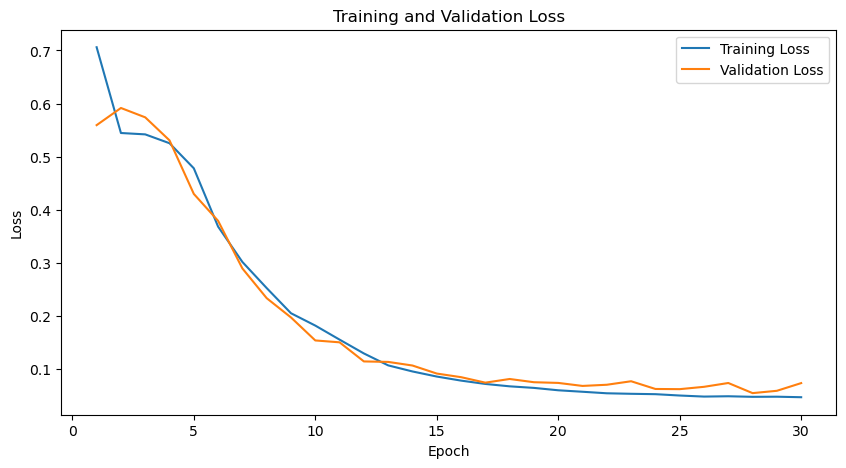

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, alpha=alpha)

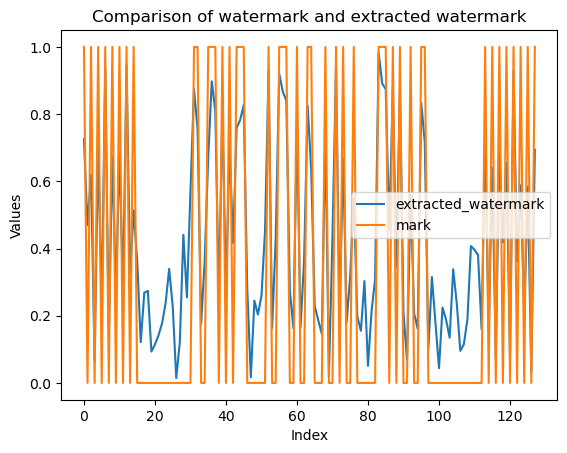

In [ ]:
X_np= extract_watermark(model, key).to("cpu").detach().numpy()

# Plot 1-X and Y on the same plot
plt.plot(X_np, label='extracted_watermark')
plt.plot(mark.cpu(), label='mark')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of watermark and extracted watermark')
plt.legend()
plt.show()

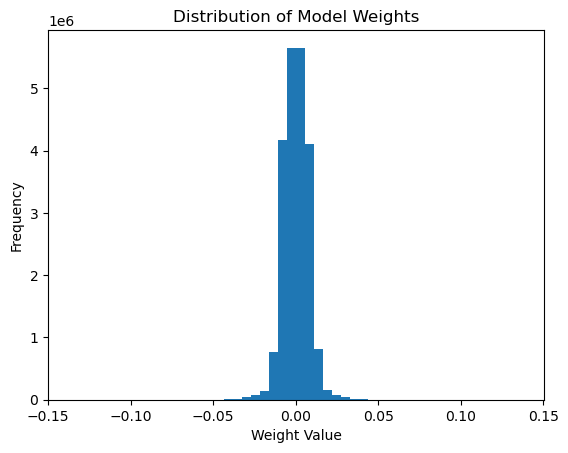

In [ ]:
params = list(model.parameters())

# Flatten and concatenate all the parameters into a single tensor
weights = torch.cat([param.view(-1) for param in params])

# Plot histogram
plt.hist(weights.detach().cpu().numpy(), bins=50)
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Distribution of Model Weights')
plt.show()


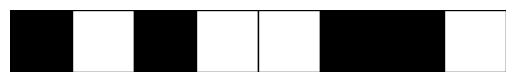

In [ ]:
def draw_boxes(binary_list, box_size=1.0, edge_color='black', edge_width=1.0):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i, value in enumerate(binary_list):
        face_color = 'white' if value >= 0.5 else 'black'
        rect = plt.Rectangle((i * box_size, 0), box_size, box_size, facecolor=face_color, edgecolor=edge_color, linewidth=edge_width)
        ax.add_patch(rect)

    plt.xlim(0, len(binary_list) * box_size)
    plt.ylim(0, box_size)
    plt.show()

# Example usage
binary_list = [0, 1, 0, 1, 1, 0, 0, 1]
draw_boxes(binary_list, box_size=2.0, edge_color='black', edge_width=1.0)

In [ ]:
def draw_difference(binary_list,binary_list_2,box_size=1.0, edge_color='black', edge_width=1.0):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()
    binary_np=np.array([tensor.item() for tensor in binary_list])
    binary_np_2=np.array([tensor.item() for tensor in binary_list_2])
    difference=np.abs(binary_np-binary_np_2)
    for i, value in enumerate(difference):
        face_color = 'red' if value >= 0.5 else 'green'
        rect = plt.Rectangle((i * box_size, 0), box_size, box_size, facecolor=face_color, edgecolor=edge_color, linewidth=edge_width)
        ax.add_patch(rect)

    plt.xlim(0, len(binary_list) * box_size)
    plt.ylim(0, box_size)
    plt.show()

the original message is: 


the recovered message is: 


the difference is :


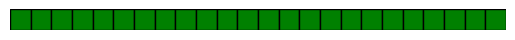

In [ ]:
print('the original message is: ')
draw_boxes(mark, box_size=2.0, edge_color='black', edge_width=1.0)
print('the recovered message is: ')
draw_boxes(X_np, box_size=2.0, edge_color='black', edge_width=1.0)
print('the difference is :')
draw_difference(X_np[0:24],mark[0:24],box_size=2.0, edge_color='black', edge_width=1.0)

In [ ]:
def calculate_ber(binary_tensor, continuous_tensor):
    # Ensure tensors are of the same shape
    assert binary_tensor.shape == continuous_tensor.shape, "Tensors must have the same shape"

    # Flatten tensors to 1D arrays
    binary_flat = binary_tensor.flatten().cpu()
    continuous_flat = continuous_tensor.flatten()

    # Convert continuous tensor to binary based on threshold 0.5
    binary_pred = (continuous_flat >= 0.5)

    # Calculate bit errors
    errors = torch.abs(binary_flat - binary_pred).sum().item()

    # Calculate bit error rate
    ber = errors / binary_flat.numel()

    return ber

In [ ]:
ber = calculate_ber(mark, X_np)
print("Bit Error Rate:", ber)

Bit Error Rate: 0.0078125


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the model
model_path = "models/ushida_reduced/model_epoch_30.pt"
# Load the saved file
checkpoint = torch.load(model_path)

# Extract and load only the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # Set the model to evaluation mode

# Assuming this is your existing code
for batch in val_loader:
    test_input = batch[0].to(device)
    gt = batch[1].to(device)
    break

output = model(test_input)
output_image = output.squeeze().detach().cpu().numpy()  # Assuming output is a tensor
gt = gt.cpu()
test_input = test_input.cpu()
im = 1 #image number 0, 1 etc here 1
sli = 13 # slice to print
test_input = test_input[im,:,:,:,:]
gt = gt[im]
output_image = output_image[im,:,:,:]

# Convert logits to class indices by taking the argmax
output_classes = np.argmax(output_image, axis=0)

# Define a colormap with 4 distinct colors
cmap = mcolors.ListedColormap(['black', 'green', 'blue', 'yellow'])

# Displaying the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(test_input[0,:,:,2])
plt.title('Image T1CE')

plt.subplot(1, 4, 2)
plt.imshow(test_input[1,:,:,2])
plt.title('Image FLAIR')

plt.subplot(1, 4, 3)
plt.imshow(gt[:,:,sli], cmap=cmap)
plt.title('Ground Truth')

plt.subplot(1, 4, 4)
plt.imshow(output_classes[:,:,sli], cmap=cmap)
plt.title('Segmented Output')

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'models/ushida_reduced/model_epoch_30.pt'